# Goal

The intent of this notebook is to give an example of hyperopt in action, on a simple dataset.

As our example, we build a classifier to predict affairs in marriages, using the 'affairs' dataset from [statsmodels](http://statsmodels.sourceforge.net/). 

# Outline

- [Section 1](#DataSource): Prepare the data and split into train/test/cross-validation sets.
- [Section 2](#HandTune): Build a hand-tuned classifier using a [random forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from sklearn. 
- [Section 3](#hyperopt1): Use [hyperopt](https://github.com/hyperopt/hyperopt) with a [tree of parzen estimators](http://optunity.readthedocs.io/en/latest/_modules/optunity/solvers/TPE.html) to tune the hyperparameters of the random forest.
- [Section 4](#hyperopt2): Repeat the above, this time using hyperopt to simultaneously tune model hyperparameters and choose between using [XGBoost](https://github.com/dmlc/xgboost) and a random forest.


For more information on Bayesian Optimization, see the paper [Algorithms for Hyperparameter Optimization](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf) by Bergstra, Bardenet, Bengio and Kégl.

In [1]:
import pandas as pd
import numpy as np

# data
import statsmodels.api as sm

# train-test split
from sklearn.cross_validation import train_test_split

# models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from functools import partial 

# performance metrics
from sklearn.metrics import roc_curve, auc, f1_score, average_precision_score, r2_score
from sklearn.metrics import confusion_matrix

# viz
from pandas.tools.plotting import scatter_matrix
%matplotlib inline

<a id='DataSource'></a>

# Data source and prep

In [2]:
print(sm.datasets.fair.SOURCE)
print( sm.datasets.fair.NOTE)


Fair, Ray. 1978. "A Theory of Extramarital Affairs," `Journal of Political
    Economy`, February, 45-61.

The data is available at http://fairmodel.econ.yale.edu/rayfair/pdf/2011b.htm

::

    Number of observations: 6366
    Number of variables: 9
    Variable name definitions:

        rate_marriage   : How rate marriage, 1 = very poor, 2 = poor, 3 = fair,
                        4 = good, 5 = very good
        age             : Age
        yrs_married     : No. years married. Interval approximations. See
                        original paper for detailed explanation.
        children        : No. children
        religious       : How relgious, 1 = not, 2 = mildly, 3 = fairly,
                        4 = strongly
        educ            : Level of education, 9 = grade school, 12 = high
                        school, 14 = some college, 16 = college graduate,
                        17 = some graduate school, 20 = advanced degree
        occupation      : 1 = student, 2 = farming,

### Read and prepare data:

In [3]:
df = pd.DataFrame(sm.datasets.fair.load().data)
df.head(5)

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


The 'affairs' column is a 'measure of time spent in extramarital affairs' ([source](http://statsmodels.sourceforge.net/0.6.0/datasets/generated/fair.html)).

We convert this to a boolean: was there an affair or not?

In [4]:
df['affairs'] = (df.affairs > 0).astype(int)
df.head(1)

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1


We do a tiny bit of feature engineering:

In [5]:
df["marriage_age_ratio"]      = df.yrs_married/df.age
df["marriage_children_ratio"] = df.children/df.yrs_married

Finally, convert categorical variables into dummy variables:

In [6]:
df = pd.concat([
        df, 
        pd.get_dummies(df.occupation, prefix = 'occupation'), 
        pd.get_dummies(df.occupation_husb, prefix = 'occupation_husb')
    ], axis=1)
df.drop(['occupation', 'occupation_husb'], inplace = True, axis = 1)

### Train/test split

Split the data into three sets: train, test and cross-validation. We choose a 70/15/15 split.

In [7]:
use_these         = [col for col in df.columns if col != 'affairs']
column_to_predict = 'affairs'
train_size        = .7

tr1, te1  = train_test_split(df[df.affairs == 1], train_size = train_size)
te1, cv1  = train_test_split(te1, test_size=0.5)

tr0, te0 = train_test_split(df[df.affairs == 0], train_size = train_size)
te0, cv0 = train_test_split(te0, test_size = 0.5)


train = pd.concat([tr1, tr0], axis=0)
test  = pd.concat([te1, te0], axis=0)
cv    = pd.concat([cv1, cv0], axis=0)

Xtest = test[use_these]
ytest = test[column_to_predict].values

Xcv = cv[use_these]
ycv = cv[column_to_predict].values

X = train[use_these]
y = train[column_to_predict].values

<a id='HandTune'></a>

# Model hand-tuning: Random Forest

In [23]:
# Fit the model
clf = RandomForestClassifier(
            n_estimators = 100,
            max_depth    = 9
)
clf.fit(X, y)

# And predict
ypred   = clf.predict(Xtest)
ypredcv = clf.predict(Xcv)

In [24]:
print 'Test data:'
f1          = f1_score(ytest, ypred)
print 'f1:', f1

fpr, tpr, _ = roc_curve(ytest, ypred)
auc_roc     = auc(fpr, tpr)
print 'auc roc:', auc_roc

auc_pr      = average_precision_score(ytest, ypred)
print 'auc pr:', auc_pr

print 'confusion matrix:'
print np.array(confusion_matrix(ypred, ytest))

Test data:
f1: 0.401709401709
auc roc: 0.601592765812
auc pr: 0.558389287414
confusion matrix:
[[581 214]
 [ 66  94]]


In [25]:
print 'CV data:'
f1          = f1_score(ycv, ypredcv)
print 'f1:', f1

fpr, tpr, _ = roc_curve(ycv, ypredcv)
auc_roc     = auc(fpr, tpr)
print 'auc roc:', auc_roc

auc_pr      = average_precision_score(ycv, ypredcv)
print 'auc pr:', auc_pr

print 'confusion matrix:'
print np.array(confusion_matrix(ypredcv, ycv))

CV data:
f1: 0.459290187891
auc roc: 0.631430779422
auc pr: 0.603873776938
confusion matrix:
[[586 198]
 [ 61 110]]


<a id='hyperopt1'></a>

# Tuning with hyperopt: Random Forest

Define your search space. Hyperopt allows you to define a prior distribution on each parameter; we choose uniform.

In [28]:
space = {
            "n_estimators" :      hp.quniform("n_estimators", 25, 500, 25),
            "criterion":          hp.choice("criterion", ['gini', 'entropy']),
            "max_depth":          hp.quniform("max_depth", 2, 20, 1),
            "max_leaf_nodes":     hp.quniform("max_leaf_nodes", 2, 100, 1),
            "min_samples_split":  hp.quniform("min_samples_split", 10, 500, 10),
            "min_weight_fraction_leaf": hp.quniform("min_weight_fraction_leaf", .1, 0.5, .05),
            "max_features":       hp.quniform("max_features", 0.1, 1, .1)
          }

And define your objective function. Here, we fit a model on a training set, and compute the AUC on a testing set. 

This is the function we want to optimize: we want the hyperparameters that give us the highest AUC on a test set. (Note that this is just an example of one choice of metric!)

In [ ]:
def FitModelAndComputeMetrics(X, y, Xtest, ytest, parameters):
#    print 'Trying the following model:'
#    print '\t', parameters
    
    # Fit the model:
    fitted_model = RandomForestClassifier(
                        n_estimators        = int(parameters['n_estimators']),
                        criterion           = parameters['criterion'],
                        max_depth           = int(parameters['max_depth']),
                        min_samples_split   = int(parameters['min_samples_split']),
                        min_weight_fraction_leaf = parameters['min_weight_fraction_leaf'],
                        max_features        = parameters['max_features'],
                        max_leaf_nodes      = int(parameters['max_leaf_nodes']),
                        # set the number of jobs to the number of cores.
                        n_jobs              = -1
                    )

    fitted_model.fit(X,y)
    # Make predictions:
    ypred = fitted_model.predict(Xtest)
    
    # Compute metric
    fpr, tpr, _ = roc_curve(ytest, ypred)
    auc_roc     = auc(fpr, tpr)
    #print 'auc roc:', auc_roc

    # And return the auc roc - this is what we want to optimize
    return auc_roc

And run the optimization! By design, hyperopt's main function, `fmin`, will attempt to minimize whatever function is given to it, so we minimize the negative of `FitModelAndComputeMetrics`.

We pass in our search space and algorithm (tree of parzen estimators), and we tell `fmin` to run 500 rounds of optimization.

The `Trials` object allows us to record every set of hyperparameters that we've seen, which we will look at later.

In [18]:
trials = Trials()

best = fmin(
            lambda parameters: -FitModelAndComputeMetrics(X, y, Xtest, ytest, parameters),
            space     = space,
            algo      = partial(tpe.suggest, n_startup_jobs=10),
            max_evals = 500,
            trials    = trials
        )

### Look at the model chosen by `hyperopt`:

In [19]:
best

{'criterion': 0,
 'max_depth': 2.0,
 'max_features': 0.8,
 'max_leaf_nodes': 18.0,
 'min_samples_split': 400.0,
 'min_weight_fraction_leaf': 0.2,
 'n_estimators': 100.0}

In [20]:
clf = RandomForestClassifier(
            criterion                = ['gini', 'entropy'][best['criterion']],
            n_estimators             = int(best['n_estimators']),
            max_depth                = int(best['max_depth']),
            max_features             = best['max_features'],
            min_samples_split        = int(best['min_samples_split']),
            min_weight_fraction_leaf = int(best['min_weight_fraction_leaf'])
)
clf.fit(X, y)
ypred   = clf.predict(Xtest)
ypredcv = clf.predict(Xcv)

In [26]:
print 'Test data:'
f1          = f1_score(ytest, ypred)
print 'f1:', f1

fpr, tpr, _ = roc_curve(ytest, ypred)
auc_roc     = auc(fpr, tpr)
print 'auc roc:', auc_roc

auc_pr      = average_precision_score(ytest, ypred)
print 'auc pr:', auc_pr

print 'confusion matrix:'
print np.array(confusion_matrix(ypred, ytest))

Test data:
f1: 0.46694214876
auc roc: 0.634755314238
auc pr: 0.606558526552
confusion matrix:
[[584 195]
 [ 63 113]]


In [27]:
print 'CV data:'
f1          = f1_score(ycv, ypredcv)
print 'f1:', f1

fpr, tpr, _ = roc_curve(ycv, ypredcv)
auc_roc     = auc(fpr, tpr)
print 'auc roc:', auc_roc

auc_pr      = average_precision_score(ycv, ypredcv)
print 'auc pr:', auc_pr

print 'confusion matrix:'
print np.array(confusion_matrix(ypredcv, ycv))

CV data:
f1: 0.787456445993
auc roc: 0.863685946009
auc pr: 0.807463088267
confusion matrix:
[[781  36]
 [ 25 113]]


### Visualize search space:

Here are pairwise scatter plots of all the points the optimizer tried. This helps us identify places where the algorithm thought that it would find a successful model. 

For example, the optimizer preferred a lower value for `min_weight_fraction_leaf` and a higher value for `max_features`.

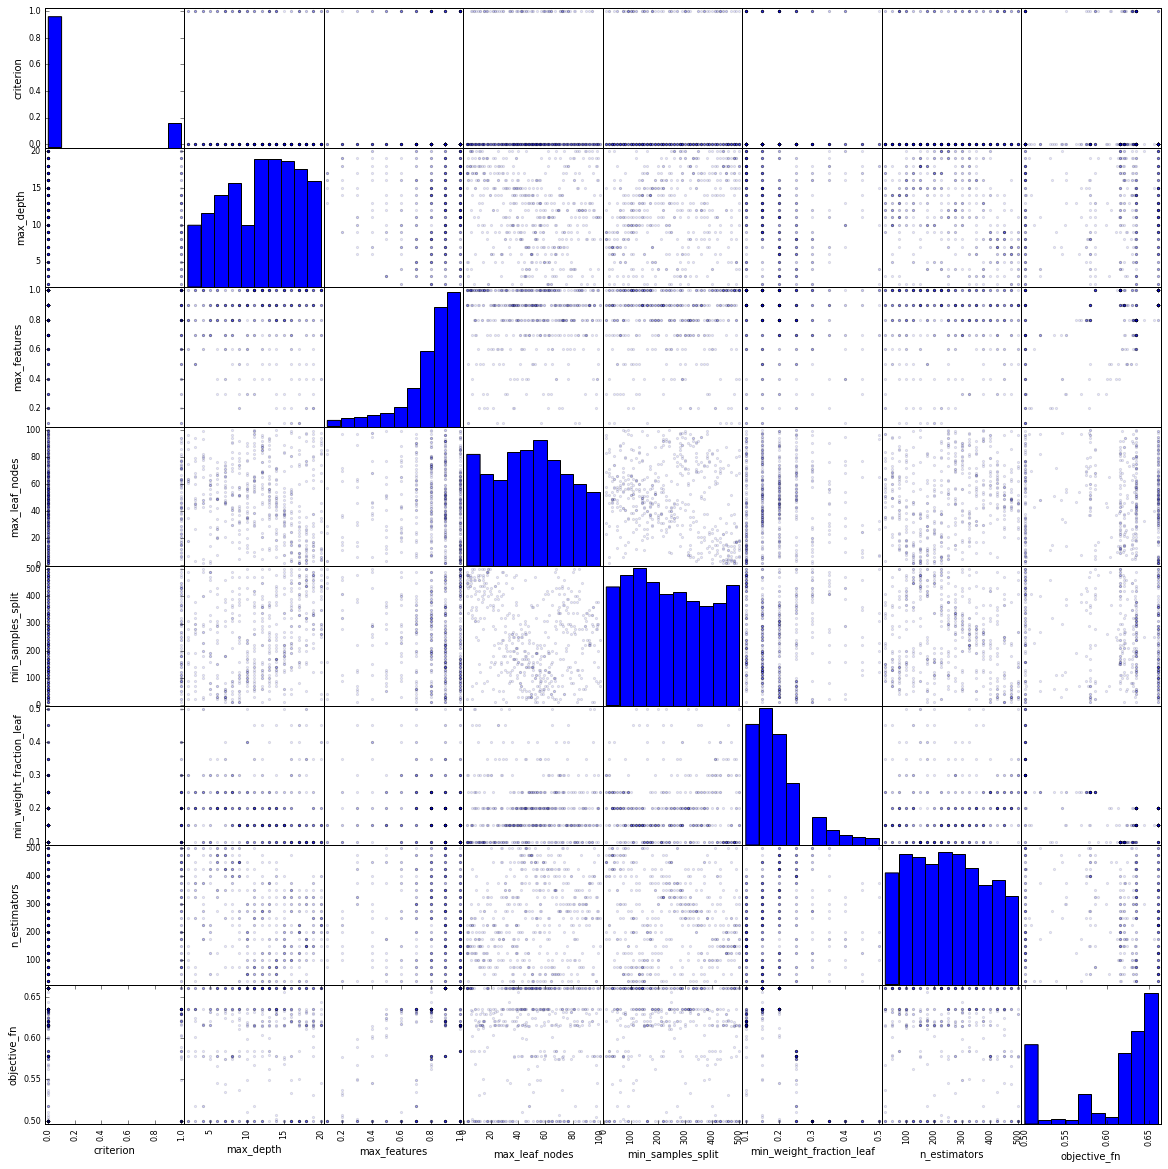

In [28]:
trials_df = pd.DataFrame(trials.vals)
trials_df["objective_fn"] = [-x for x in trials.losses()]
scatter_matrix(trials_df, alpha=0.1, figsize=(20, 20), diagonal='hist');

<a id='hyperopt2'></a>

# Tuning with hyperopt: Random Forest and XGBoost

We repeat hyperparameter tuning, this time allowing the algorithm to choose between a random forest and a gradient boosted tree.

We just have two changes to make to our code:

1. Define a new search space to include gradient boosted trees.
2. Update `FitModelAndComputeMetrics` to train either a random forest or gradient boosted tree, depending on the parameters given by `fmin`.

Here is our new search space:

In [55]:
space = hp.choice("model_class",
           [
            {
                "model_type":        'RF',
                "n_estimators" :      hp.quniform("n_estimators_rf", 25, 500, 25),
                "criterion":          hp.choice("criterion_rf", ['gini', 'entropy']),
                "max_depth":          hp.quniform("max_depth_rf", 2, 20, 1),
                "max_leaf_nodes":     hp.quniform("max_leaf_nodes_rf", 2, 100, 1),
                "min_samples_split":  hp.quniform("min_samples_split_rf", 10, 500, 10),
                "min_weight_fraction_leaf": hp.quniform("min_weight_fraction_leaf_rf", .1, 0.5, .05),
                "max_features":       hp.quniform("max_features_rf", 0.1, 1, .1)
              },
             {
                "model_type":          'XGB',
                'eta':                 hp.quniform("eta_xgb", 0, 1, .05), 
                'max_depth':           hp.quniform("max_depth_xgb", 2, 10, 1),
                'min_child_weight':    hp.quniform("min_child_weight_xgb", 10, 100, 10),
                'max_delta_step':      hp.quniform("max_delta_step_xgb", 1, 10, 1),
                'subsample':           hp.quniform("subsample_xgb", 0.05, 1, .05),
                'colsample_bytree':    hp.quniform("colsample_bytree_xgb", 0.1, 1, .1),
                'num_boost_round':     hp.quniform("num_boost_round_xgb", 50, 500, 50)
            }
        ]
)

And here is our new function; we allow the model type to be either a random forest or a gradient boosted tree.

In [56]:
def FitModelAndComputeMetric2(X, y, Xtest, ytest, parameters):
    if parameters['model_type'] == 'RF':
        fitted_model = RandomForestClassifier(
                        n_estimators        = int(parameters['n_estimators']),
                        criterion           = parameters['criterion'],
                        max_depth           = int(parameters['max_depth']),
                        min_samples_split   = int(parameters['min_samples_split']),
                        min_weight_fraction_leaf = parameters['min_weight_fraction_leaf'],
                        max_features        = parameters['max_features'],
                        max_leaf_nodes      = int(parameters['max_leaf_nodes']),
                        # set the number of jobs to the number of cores.
                        n_jobs              = -1
                        )

        fitted_model.fit(X,y)
        ypred = fitted_model.predict(Xtest)
        
    else:
        dtrain = xgb.DMatrix(X, label = y, missing = float('NaN'))
        fitted_model = xgb.train(
                        parameters,
                        dtrain,
                        int(parameters['num_boost_round'])#,
                        #[(dtrain, 'train')],
                        #verbose_eval=100
                       )
        ypred = fitted_model.predict(xgb.DMatrix(Xtest, missing = float('NaN')))
  
    # Compute metric
    fpr, tpr, _ = roc_curve(ytest, ypred)
    auc_roc     = auc(fpr, tpr)
    #print 'auc roc:', auc_roc

    # And return the auc roc - this is what we want to optimize
    return auc_roc

And, as before, we run the optimization. This takes a while to run.

In [57]:
trials = Trials()

best = fmin(
                lambda parameters: -FitModelAndComputeMetric2(X, y, Xtest, ytest, parameters),
                space     = space,
                algo      = partial(tpe.suggest, n_startup_jobs=10),
                max_evals = 1000,
                trials    = trials
        )

### Look at 'best' model

The optimizer chose a gradient boosted tree:

In [58]:
best

{'colsample_bytree_xgb': 0.30000000000000004,
 'eta_xgb': 0.4,
 'max_delta_step_xgb': 9.0,
 'max_depth_xgb': 2.0,
 'min_child_weight_xgb': 100.0,
 'model_class': 1,
 'num_boost_round_xgb': 50.0,
 'subsample_xgb': 0.6000000000000001}

We train our tree and look at its performance metrics. Surprisingly, we didn't actually improve much over just looking at the random forest!

In [59]:
dtrain = xgb.DMatrix(X, label = y, missing = float('NaN'))
fitted_model = xgb.train(
                 {x.replace('_xgb', ''):y for x,y in best.iteritems()},
                 dtrain,
                 int(best['num_boost_round_xgb'])#,
                 # uncomment to see training error every 100 rounds
                 #[(dtrain, 'train')],
                 #verbose_eval=100
               )
ypred = fitted_model.predict(xgb.DMatrix(Xtest, missing = float('NaN')))>.5
ypredcv = fitted_model.predict(xgb.DMatrix(Xcv, missing = float('NaN')))>.5

In [60]:
print 'Test data:'
f1          = f1_score(ytest, ypred)
print 'f1:', f1

fpr, tpr, _ = roc_curve(ytest, ypred)
auc_roc     = auc(fpr, tpr)
print 'auc roc:', auc_roc

auc_pr      = average_precision_score(ytest, ypred)
print 'auc pr:', auc_pr

print 'confusion matrix:'
print np.array(confusion_matrix(ypred, ytest))

Test data:
f1: 0.469387755102
auc roc: 0.634910877376
auc pr: 0.603669498041
confusion matrix:
[[580 193]
 [ 67 115]]


In [61]:
print 'CV data:'
f1          = f1_score(ycv, ypredcv)
print 'f1:', f1

fpr, tpr, _ = roc_curve(ycv, ypredcv)
auc_roc     = auc(fpr, tpr)
print 'auc roc:', auc_roc

auc_pr      = average_precision_score(ycv, ypredcv)
print 'auc pr:', auc_pr

print 'confusion matrix:'
print np.array(confusion_matrix(ypredcv, ycv))

CV data:
f1: 0.484599589322
auc roc: 0.644417792409
auc pr: 0.620643819897
confusion matrix:
[[586 190]
 [ 61 118]]


### Visualize search space

To visualize the search space, we break it into two search spaces: one search space corresponds to the hyperparameters for random forests, and the other corresponds to hyperparameters for the gradient boosted tree.

We start by splitting our attempt history into two subsets, RF results and XGB results:

In [62]:
rf_keys  = [x.replace("_rf", "") for x in trials.vals.keys() if 'rf' in x]
xgb_keys = [x.replace("_xgb", "") for x in trials.vals.keys() if 'xgb' in x]

results_with_model_type = zip(['rf' if x == 0 else 'xgb' for x in trials.vals['model_class']], [-x['loss'] for x in trials.results])

In [63]:
rf_dict = {k:v for k,v in trials.vals.iteritems() if k.replace("_rf", "") in rf_keys}
rf_dict['score'] = [x[1] for x in results_with_model_type if x[0] == 'rf']

xgb_dict = {k:v for k,v in trials.vals.iteritems() if k.replace("_xgb", "") in xgb_keys}
xgb_dict['score'] = [x[1] for x in results_with_model_type if x[0] == 'xgb']

And now we're ready to plot the search spaces. 

The random forest search space looks rather uniform, meaning that the algorithm tried a lot of points all over the space. This tells us that the optimizer never really found a region of the random forest search space that it thought would give a 'good model'. 

The XGBoost search space, on the other hand, shows that the optimizer had areas where it thought there would be better models.

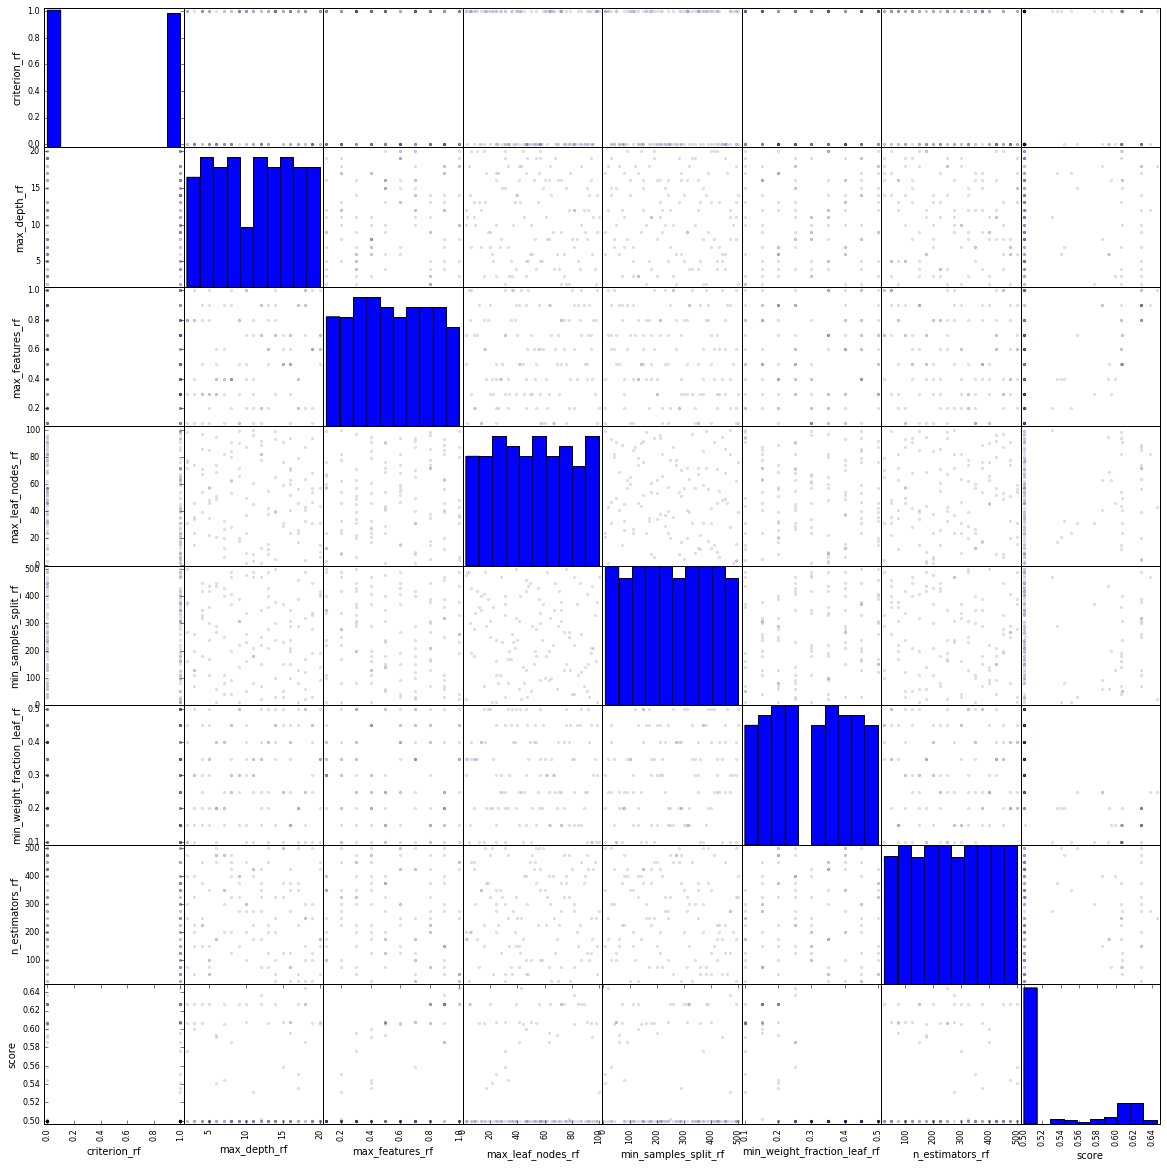

In [64]:
# RF
scatter_matrix(pd.DataFrame(rf_dict), alpha=0.1, figsize=(20, 20), diagonal='hist');

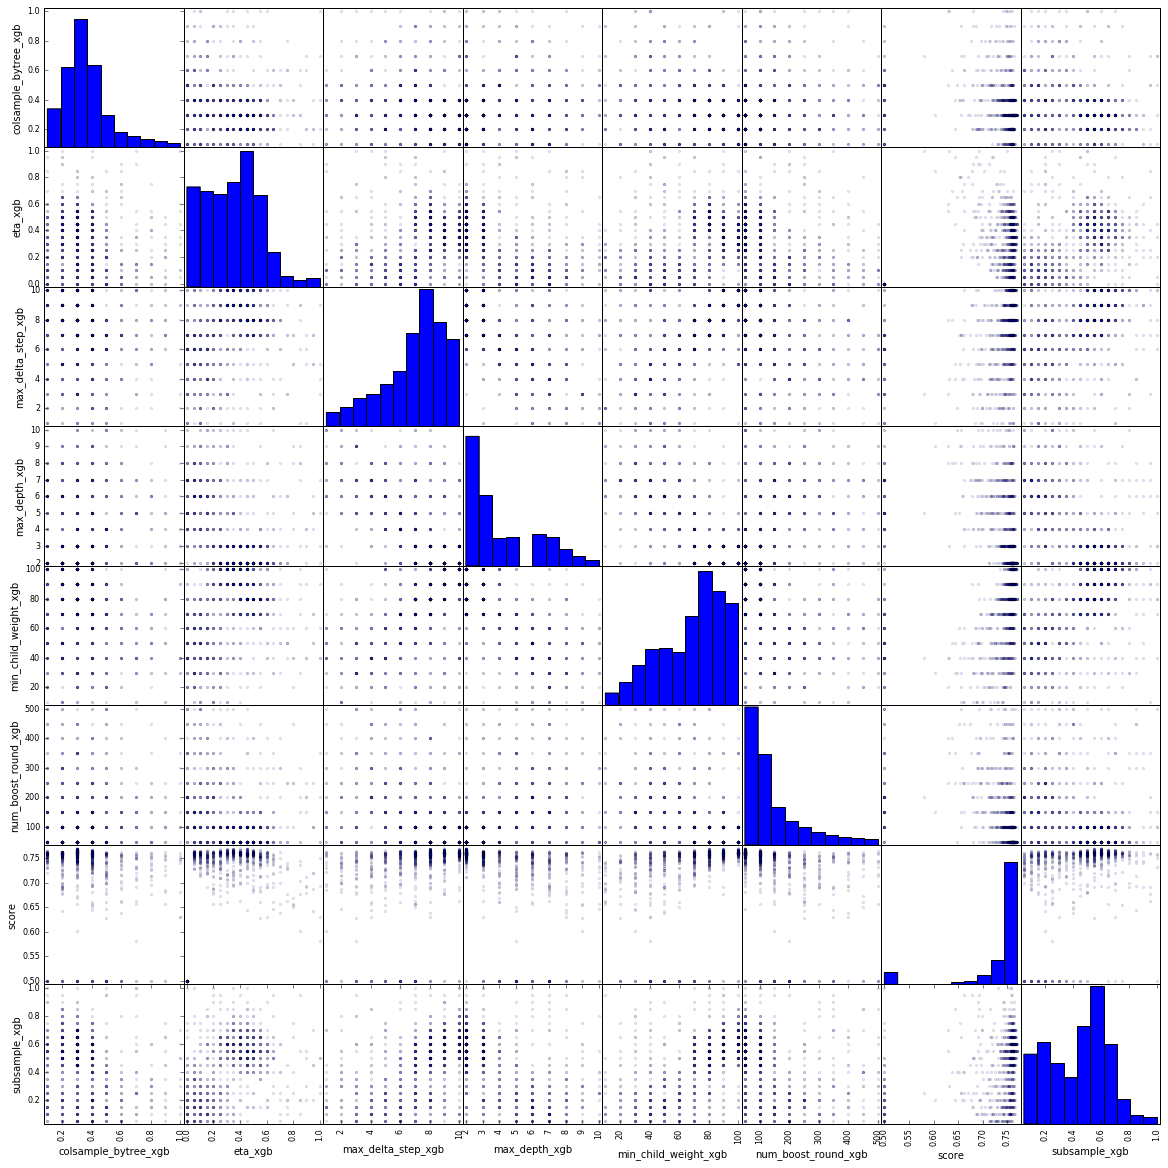

In [65]:
# XGB
scatter_matrix(pd.DataFrame(xgb_dict), alpha=0.1, figsize=(20, 20), diagonal='hist');